In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
# Function to create sequences for time-series data
def create_sequences(data, target_col, features, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target_col].iloc[i+seq_length])
    return np.array(X), np.array(y)

In [5]:
# Load your dataset
data = pd.read_csv("preprocessed_trade_data.csv")
sequence_length = 3
target_price = 'modal_price'
features = ['min_price', 'max_price','state','district','market','commodity',
            'price_spread', 'price_ratio', 'month']

In [6]:
# Filter data by commodity (example for commodity_id = 1)
commodity_id = 1
filtered_data = data[data['commodity'] == commodity_id]

In [7]:
# Create sequences
X, y = create_sequences(filtered_data, target_price, features, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Flatten the sequence data for models like Random Forest and Linear Regression
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [9]:
# Function to train LSTM
def train_lstm(X_train, y_train, X_test, y_test):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

In [37]:
# Train and evaluate different models
results = {}
results1= {}

In [42]:
# 1. LSTM Model
print("\nTraining LSTM Model...")
lstm_model, lstm_history = train_lstm(X_train, y_train, X_test, y_test)
lstm_predictions = lstm_model.predict(X_test)
results['LSTM'] = {
    "mse": mean_squared_error(y_test, lstm_predictions),
    "r2": r2_score(y_test, lstm_predictions)
}


Training LSTM Model...
Epoch 1/50


C:\Users\Manju\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0529 - mae: 0.1904 - val_loss: 0.0153 - val_mae: 0.0958
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0327 - mae: 0.1412 - val_loss: 0.0179 - val_mae: 0.0897
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0338 - mae: 0.1336 - val_loss: 0.0158 - val_mae: 0.0915
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0462 - mae: 0.1743 - val_loss: 0.0111 - val_mae: 0.0729
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0396 - mae: 0.1587 - val_loss: 0.0065 - val_mae: 0.0506
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0230 - mae: 0.1349 - val_loss: 0.0041 - val_mae: 0.0388
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0217 - mae: 0.1114 - val_loss: 0.0027 - val_mae: 0.0338
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0338 - mae: 0.1521 - val_loss: 0.0017 - val_mae: 0.0333
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0157 - mae: 0.0973 - val_l

In [43]:
# 2. Random Forest Regressor
print("\nTraining Random Forest Regressor...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)
rf_predictions = rf_model.predict(X_test_flat)
results['Random Forest'] = {
    "mse": mean_squared_error(y_test, rf_predictions),
    "r2": r2_score(y_test, rf_predictions)
}


Training Random Forest Regressor...


In [44]:
# 3. XGBoost Regressor
print("\nTraining XGBoost Regressor...")
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_flat, y_train)
xgb_predictions = xgb_model.predict(X_test_flat)
results['XGBoost'] = {
    "mse": mean_squared_error(y_test, xgb_predictions),
    "r2": r2_score(y_test, xgb_predictions)
}


Training XGBoost Regressor...


In [45]:
# 4. Linear Regression
print("\nTraining Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_flat, y_train)
lr_predictions = lr_model.predict(X_test_flat)
results['Linear Regression'] = {
    "mse": mean_squared_error(y_test, lr_predictions),
    "r2": r2_score(y_test, lr_predictions)
}


Training Linear Regression...


In [38]:
# Train Neural Network
def train_neural_network(X_train, y_train, X_test, y_test):
    # Reshape 3D input data to 2D
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Flatten sequence and features
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    
    # Initialize and train the neural network
    nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
    nn_model.fit(X_train_reshaped, y_train)
    
    # Make predictions
    nn_predictions = nn_model.predict(X_test_reshaped)
    
    # Evaluate performance
    mse = mean_squared_error(y_test, nn_predictions)
    r2 = r2_score(y_test, nn_predictions)
    
    return nn_model, mse, r2

# Add Neural Network to the study
print("\nTraining Neural Network...")
nn_model, nn_mse, nn_r2 = train_neural_network(X_train, y_train, X_test, y_test)
results1["Neural Network"] = {"mse": nn_mse, "r2": nn_r2}



Training Neural Network...


In [39]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def train_polynomial_regression(X_train, y_train, X_test, y_test, degree=3):
    # Reshape 3D input data to 2D
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Flatten the sequence and features
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    
    # Polynomial feature transformation
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train_reshaped)
    X_test_poly = poly.transform(X_test_reshaped)
    
    # Train the Polynomial Regression model
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    
    # Make predictions
    poly_predictions = poly_model.predict(X_test_poly)
    
    # Evaluate performance
    mse = mean_squared_error(y_test, poly_predictions)
    r2 = r2_score(y_test, poly_predictions)
    
    return poly_model, mse, r2

# Add Polynomial Regression to the study
print("\nTraining Polynomial Regression...")
poly_model, poly_mse, poly_r2 = train_polynomial_regression(X_train, y_train, X_test, y_test)
results1["Polynomial Regression"] = {"mse": poly_mse, "r2": poly_r2}


Training Polynomial Regression...


In [46]:
# Visualize the results
print("\nModel Performance:")
for model, metrics in results.items():
    # Corrected ternary operation for handling negative R² values
    r2_display = -metrics['r2'] if metrics['r2'] < 0 else metrics['r2']
    print(f"{model} - MSE: {metrics['mse']:.4f}, R²: {r2_display:.4f}")
for model, metrics in results1.items():
    # Corrected ternary operation for handling negative R² values
    r2_display = -metrics['r2'] if metrics['r2'] < 0 else metrics['r2']
    print(f"{model} - MSE: {metrics['mse']:.4f}, R²: {r2_display:.4f}")


Model Performance:
LSTM - MSE: 0.0002, R²: 1.7745
Random Forest - MSE: 0.0001, R²: 0.4185
XGBoost - MSE: 0.0000, R²: 0.7164
Linear Regression - MSE: 0.0003, R²: 1.9104
Neural Network - MSE: 64.8853, R²: 731495.3613
Polynomial Regression - MSE: 0.0016, R²: 16.5184


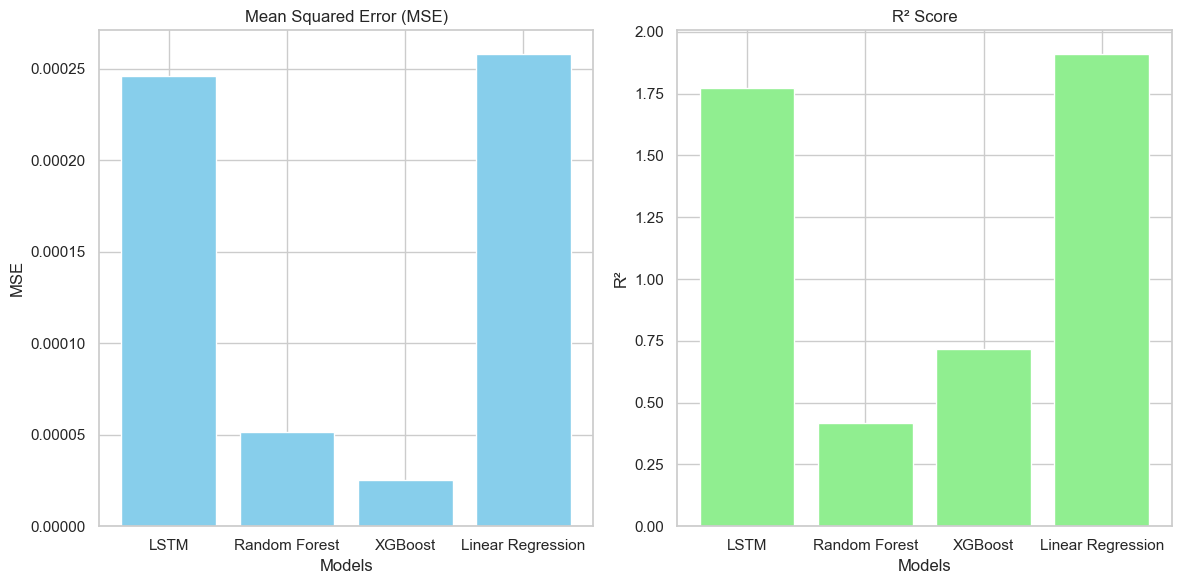

In [47]:
# Visualization of model comparison
model_names = list(results.keys())
mse_values = [results[model]['mse'] for model in model_names]
r2_values = [abs(results[model]['r2']) for model in model_names] 

plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.bar(model_names, mse_values, color='skyblue')
plt.title("Mean Squared Error (MSE)")
plt.ylabel("MSE")
plt.xlabel("Models")

# Plot R²
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values, color='lightgreen')
plt.title("R² Score")
plt.ylabel("R²")
plt.xlabel("Models")

plt.tight_layout()
plt.show()

C:\Users\Manju\AppData\Local\Temp\ipykernel_16372\1808720045.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=viz_data, x="Model", y="MSE", palette="Blues_d")
C:\Users\Manju\AppData\Local\Temp\ipykernel_16372\1808720045.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=viz_data, x="Model", y="R² Score", palette="Greens_d")


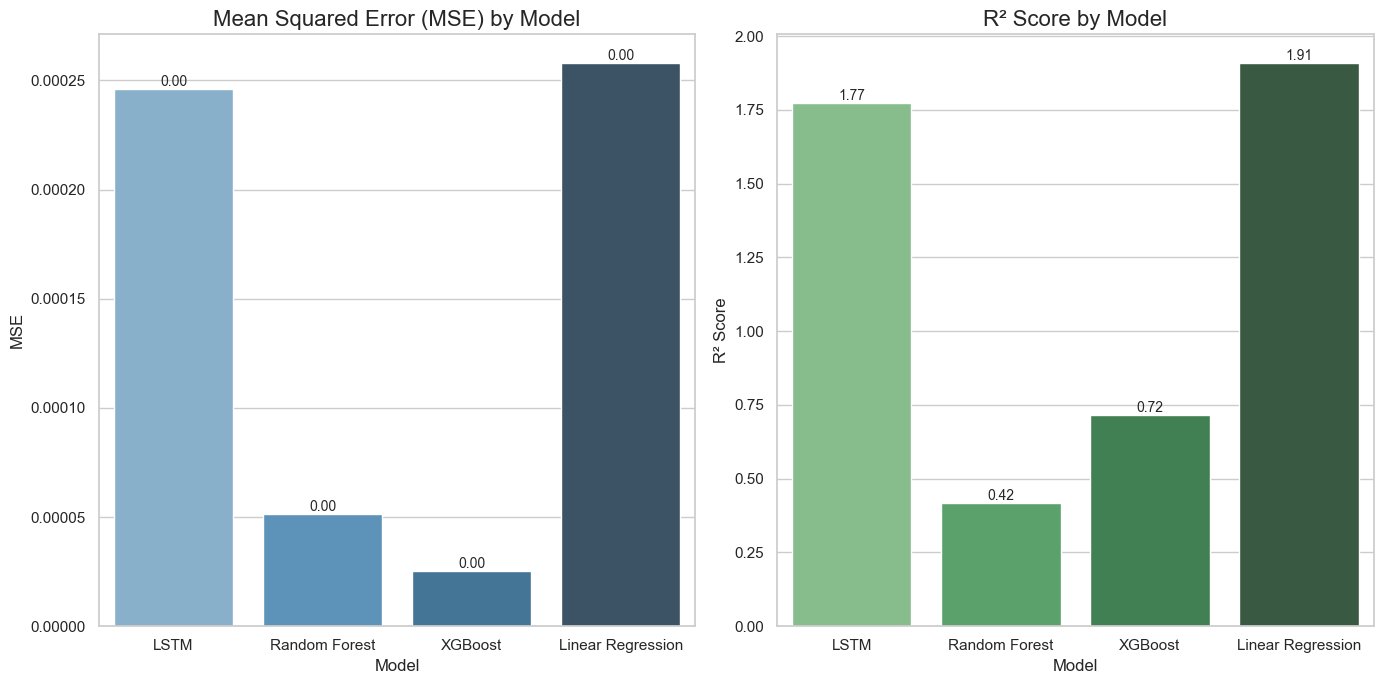

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for visualization
model_names = list(results.keys())
mse_values = [results[model]['mse'] for model in model_names]
r2_values = [
    -results[model]['r2'] if results[model]['r2'] < 0 else results[model]['r2']
    for model in model_names
]

# Create a DataFrame for easier manipulation with Seaborn
viz_data = pd.DataFrame({
    "Model": model_names,
    "MSE": mse_values,
    "R² Score": r2_values
})

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Advanced Visualization
plt.figure(figsize=(14, 7))

# Plot MSE with Seaborn
plt.subplot(1, 2, 1)
sns.barplot(data=viz_data, x="Model", y="MSE", palette="Blues_d")
plt.title("Mean Squared Error (MSE) by Model", fontsize=16)
plt.ylabel("MSE", fontsize=12)
plt.xlabel("Model", fontsize=12)
for index, value in enumerate(mse_values):
    plt.text(index, value, f"{value:.2f}", ha="center", va="bottom", fontsize=10)

# Plot R² Score with Seaborn
plt.subplot(1, 2, 2)
sns.barplot(data=viz_data, x="Model", y="R² Score", palette="Greens_d")
plt.title("R² Score by Model", fontsize=16)
plt.ylabel("R² Score", fontsize=12)
plt.xlabel("Model", fontsize=12)
for index, value in enumerate(r2_values):
    plt.text(index, value, f"{value:.2f}", ha="center", va="bottom", fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
